<a href="https://colab.research.google.com/github/jooyeongkang/social-injustice-mimic-III/blob/main/Medication_Race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr  5 23:32:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#from google.colab import files
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Start by uploading the top DRUG and ADMISSIONS files**

---



## ADMISSIONS.csv

In [ ]:
admissions_df = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
print(admissions_df.shape)
admissions_df.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


### Clean up

In [ ]:
# ETHNICITY
admissions_df['ETHNICITY'].replace('^WHITE\D*', 'WHITE', regex=True, inplace=True)
admissions_df['ETHNICITY'].replace('^BLACK\D*', 'BLACK', regex=True, inplace=True)
admissions_df['ETHNICITY'].replace('^HISPANIC\D*', 'HISPANIC/LATINO', regex=True, inplace=True)
admissions_df['ETHNICITY'].replace('^ASIAN\D*', 'ASIAN', regex=True, inplace=True)
admissions_df.loc[~admissions_df['ETHNICITY'].isin(['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN']), 'ETHNICITY'] = 'UNKNOWN/NOT SPECIFIED'

# ADMISSION_TYPE
admissions_df['ADMISSION_TYPE'].replace('URGENT', 'EMERGENCY', inplace=True)

# MARITAL_STATUS
admissions_df['MARITAL_STATUS'].replace('WIDOWED', 'SINGLE', inplace=True)
admissions_df['MARITAL_STATUS'].replace('DIVORCED', 'SINGLE', inplace=True)
admissions_df['MARITAL_STATUS'].replace('SEPARATED', 'SINGLE', inplace=True)
admissions_df['MARITAL_STATUS'].replace('LIFE PARTNER', 'MARRIED', inplace=True)

In [ ]:
ls_ethnicity = admissions_df['ETHNICITY'].unique()

### Top (100) Diagnosis

In [ ]:
top_diagnosis = admissions_df['DIAGNOSIS'].value_counts().nlargest(100).keys().to_numpy()

## PRESCRIPTIONS.csv

In [ ]:
prescriptions_df = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv')
print(prescriptions_df.shape)
prescriptions_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4156450, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


### Top (50) Drugs

In [ ]:
#top_drug = prescriptions_df['DRUG'].value_counts().nlargest(100).keys().to_numpy()
top_drug = prescriptions_df['DRUG'].value_counts().nlargest(50).keys().to_numpy()

**Filter all patients and ethnicity who were given the top drugs**

## Joined ADMISSIONS.csv and PRESCRIPTIONS.csv

In [ ]:
adm_pres_df = admissions_df.loc[admissions_df['DIAGNOSIS'].isin(top_diagnosis)].merge(prescriptions_df[['SUBJECT_ID', 'HADM_ID', 'DRUG']].loc[prescriptions_df['DRUG'].isin(top_drug)], how='left', on=['SUBJECT_ID', 'HADM_ID'])
adm_pres_df.drop(columns=['ROW_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'LANGUAGE', 'RELIGION', 'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'], inplace=True)
print(adm_pres_df.shape)
adm_pres_df.head()

(1133859, 8)


,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DRUG
0,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,Nitroglycerin
1,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,LR
2,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,D5W
3,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,NS
4,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,SW


### One-Hot Encoding: DRUG

In [ ]:
tmp = pd.concat([adm_pres_df, pd.get_dummies(adm_pres_df['DRUG'])], axis=1).groupby(['SUBJECT_ID', 'HADM_ID']).sum().reset_index()
tmp

,SUBJECT_ID,HADM_ID,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin
0,2,163353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,145834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,178980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,118037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,159514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30978,99965,101083,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
30979,99973,150202,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,4,0,0,0,2,0,0,2,0,0,0,0
30980,99982,112748,2,4,0,0,1,0,0,7,1,0,4,0,1,0,0,6,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,2,0,4,0,0,0,2
30981,99985,176670,15,6,4,1,0,0,1,0,0,0,1,0,2,0,4,2,0,0,1,0,0,1,4,0,1,0,4,0,0,0,0,1,1,0,3,0,2,0,5,0,0,0,3,1,2,3,1,0,0,0


In [ ]:
adm_pres_df = adm_pres_df.merge(tmp, how='left', on=['SUBJECT_ID', 'HADM_ID']).drop(['DRUG'], axis=1)
adm_pres_df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin
0,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
1,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
2,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
3,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
4,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0


#### The nubmer of prescription of each drug in the same ethnicity 

In [ ]:
ls_total = []
final_df = pd.DataFrame(ls_ethnicity, columns=['ETHNICITY'])

for drug in top_drug:
  ls_mean = []

  for race in ls_ethnicity:
    ls_mean.append(adm_pres_df.loc[adm_pres_df['ETHNICITY'] == race, drug].mean())

  ls_total.append(ls_mean)
  final_df = pd.concat([final_df, pd.DataFrame(ls_mean, columns=[drug])], axis=1)

final_df

,ETHNICITY,Potassium Chloride,Insulin,D5W,Furosemide,0.9% Sodium Chloride,NS,Magnesium Sulfate,Iso-Osmotic Dextrose,Sodium Chloride 0.9% Flush,Acetaminophen,Metoprolol,5% Dextrose,SW,Morphine Sulfate,Metoprolol Tartrate,Lorazepam,Calcium Gluconate,Heparin,Docusate Sodium,Vancomycin,Bisacodyl,Warfarin,Heparin Sodium,HYDROmorphone (Dilaudid),LR,Propofol,Pantoprazole,Fentanyl Citrate,Senna,Aspirin,Bag,Vial,Vancomycin HCl,Albuterol 0.083% Neb Soln,Dextrose 50%,Oxycodone-Acetaminophen,Ondansetron,Levofloxacin,Haloperidol,Ranitidine,Aspirin EC,Ipratropium Bromide Neb,Famotidine,Lisinopril,Sodium Bicarbonate,Neutra-Phos,Potassium Phosphate,Pantoprazole Sodium,Atorvastatin,Nitroglycerin
0,WHITE,7.123158,4.998318,5.347297,5.255536,4.886933,4.740463,3.030418,3.171027,2.232429,2.206698,2.460561,3.084351,2.982793,1.805543,2.320865,1.880916,2.032607,1.518539,1.199193,1.764182,1.168473,1.311598,1.343621,1.102728,1.345769,1.298603,0.898092,1.316607,0.786309,0.827941,0.891268,0.840170,0.747741,0.740933,0.668694,0.500958,0.543004,0.620419,0.836828,0.564551,0.524186,0.618596,0.512477,0.475431,0.692298,0.648061,0.662249,0.556643,0.484469,0.547158
1,UNKNOWN/NOT SPECIFIED,7.303755,5.490022,6.047044,5.694752,4.974589,4.013293,2.993114,3.440614,2.008412,2.315618,2.912254,3.076282,2.884726,1.717695,2.036619,1.528064,2.250048,1.229438,1.331291,1.698826,1.199305,1.101454,1.288145,0.761024,0.842555,1.347340,1.087250,1.331866,0.664595,0.879861,1.102149,0.740326,1.106215,0.578663,0.782218,0.701222,0.419396,0.627385,0.754705,0.862143,0.864116,0.525763,0.501973,0.497308,0.829973,0.608859,0.619851,0.494496,0.586444,0.737937
2,BLACK,6.529644,7.545718,5.369301,4.624246,5.559711,5.101304,2.914026,3.444902,2.143696,1.923526,1.890086,3.247182,2.700001,1.559275,1.699992,1.617809,1.807612,1.737686,1.020627,1.966047,1.075002,1.016758,0.906434,1.117095,1.204781,0.963796,0.986699,1.423932,0.915677,0.795253,1.096776,1.252908,0.803487,0.762661,0.831098,0.324212,0.624417,0.696312,0.667622,0.230218,0.249373,0.637349,0.454950,0.636699,0.933489,0.680007,0.587562,0.553010,0.367110,0.319479
3,HISPANIC/LATINO,6.446634,5.726626,3.996715,4.039084,6.372941,4.200609,2.582429,3.348472,2.360254,2.194421,1.520351,3.950467,2.309554,1.905717,1.861135,1.928520,1.841879,1.644078,1.127011,2.151314,1.097996,0.717819,1.198372,1.677640,1.109040,1.291607,0.933376,1.502047,0.780158,0.671903,1.357350,0.869085,0.590046,0.735885,0.753689,0.416905,0.622584,0.594735,0.631962,0.488741,0.389413,0.543559,0.648910,0.484647,0.493811,0.678282,0.670570,0.423593,0.315148,0.406979
4,ASIAN,6.223522,4.733575,2.719088,3.556936,7.271137,3.941737,2.643301,2.986525,2.464079,2.348984,1.811213,4.447253,1.810549,1.664281,2.324653,1.265831,2.139985,1.526496,1.131083,2.058647,1.107310,1.055854,0.832228,0.867346,1.380263,1.156601,0.875201,1.136005,0.888920,0.825351,1.218146,0.937757,0.401836,0.664700,0.772743,0.372722,0.686693,0.526182,0.427320,0.444251,0.373665,0.549885,0.648014,0.534350,0.717936,0.767542,0.753857,0.576730,0.458214,0.409586


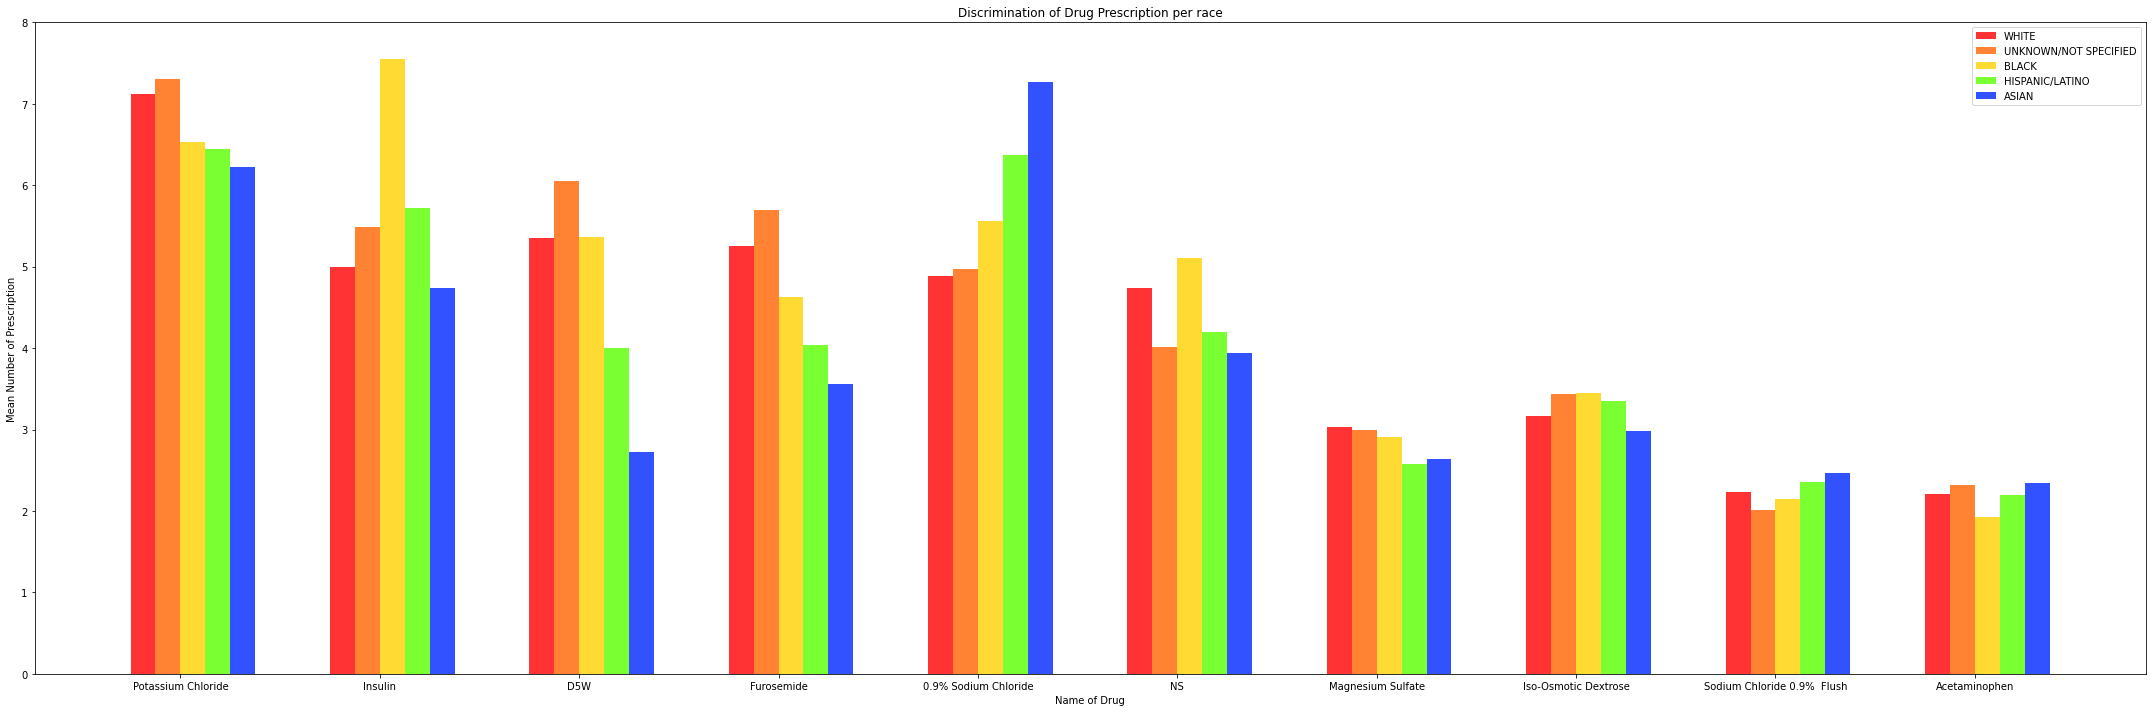

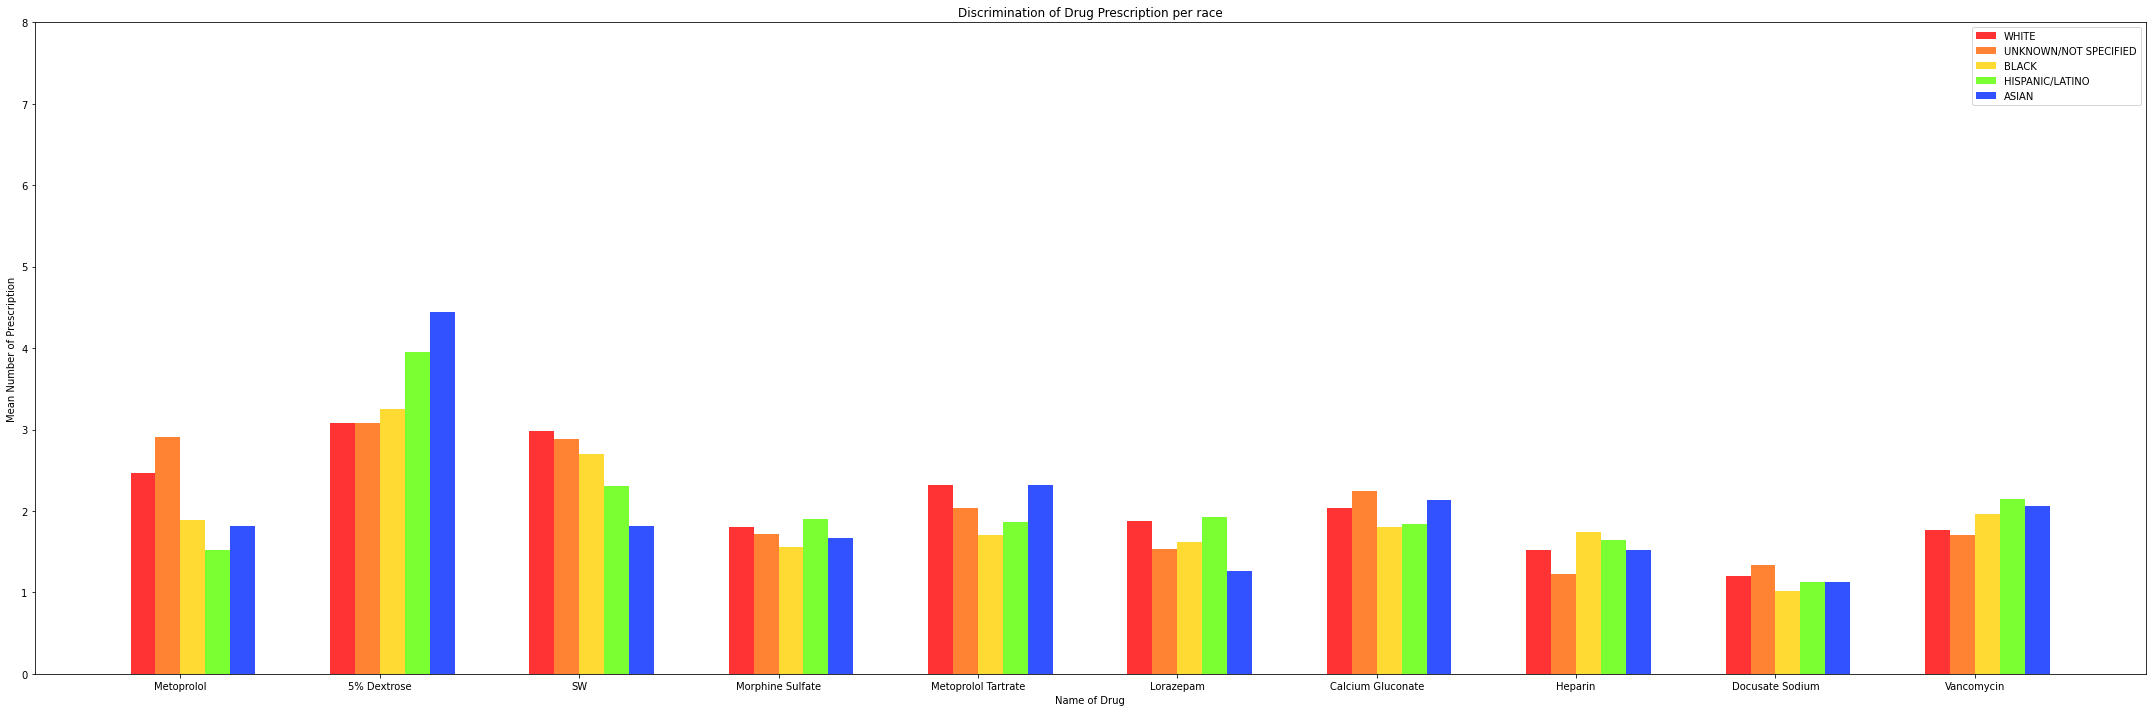

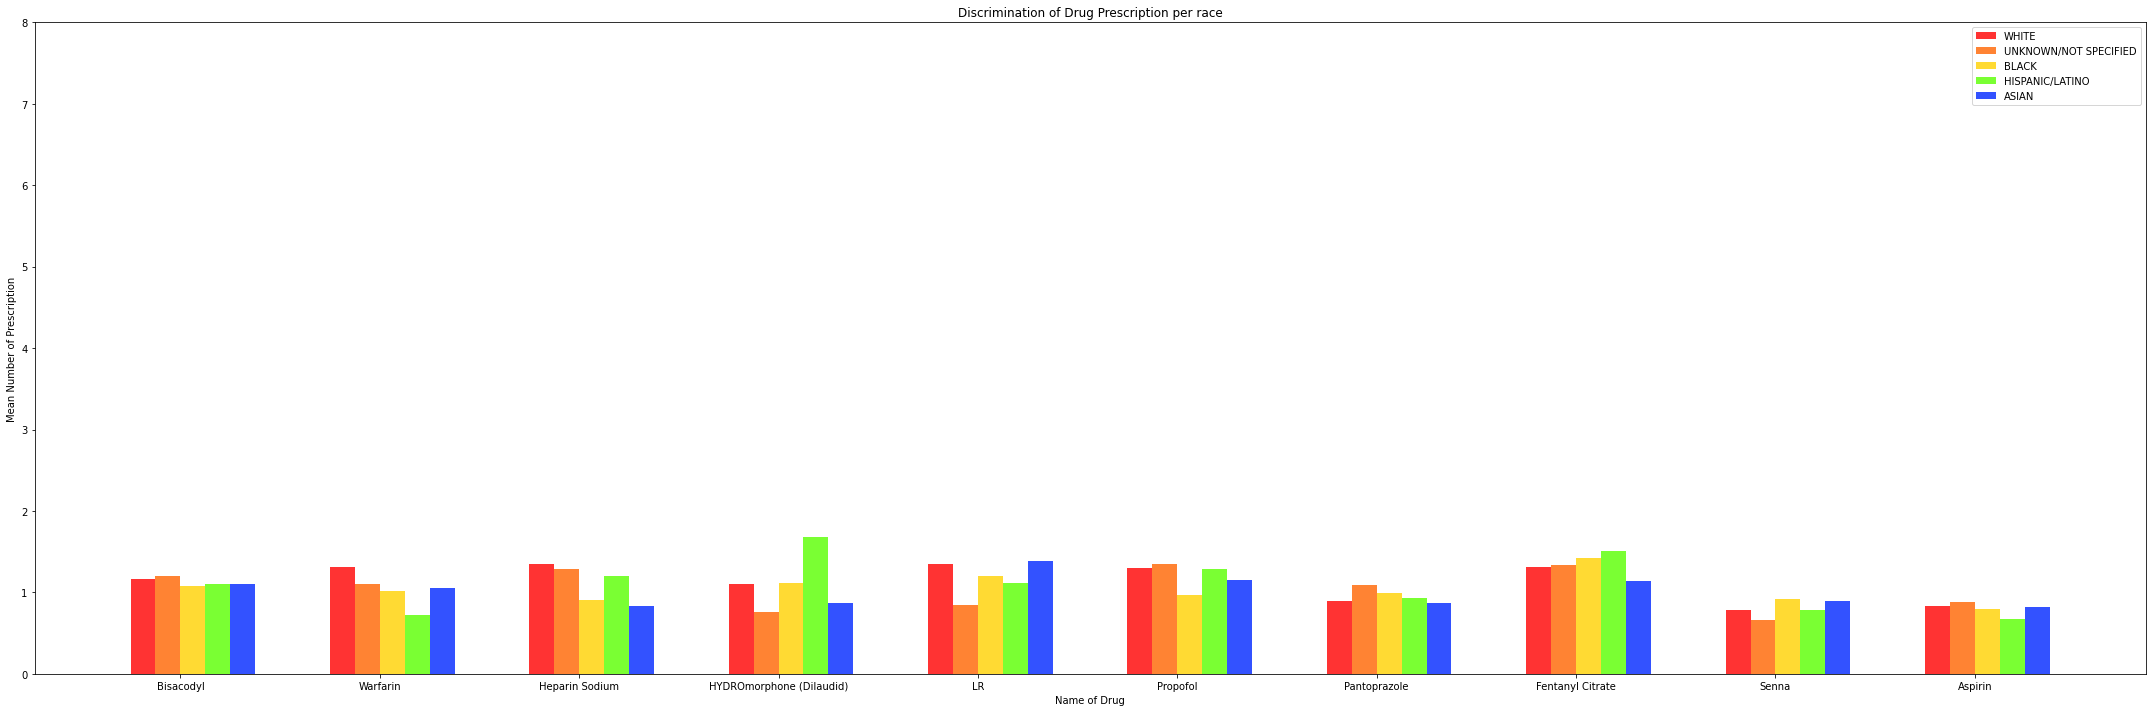

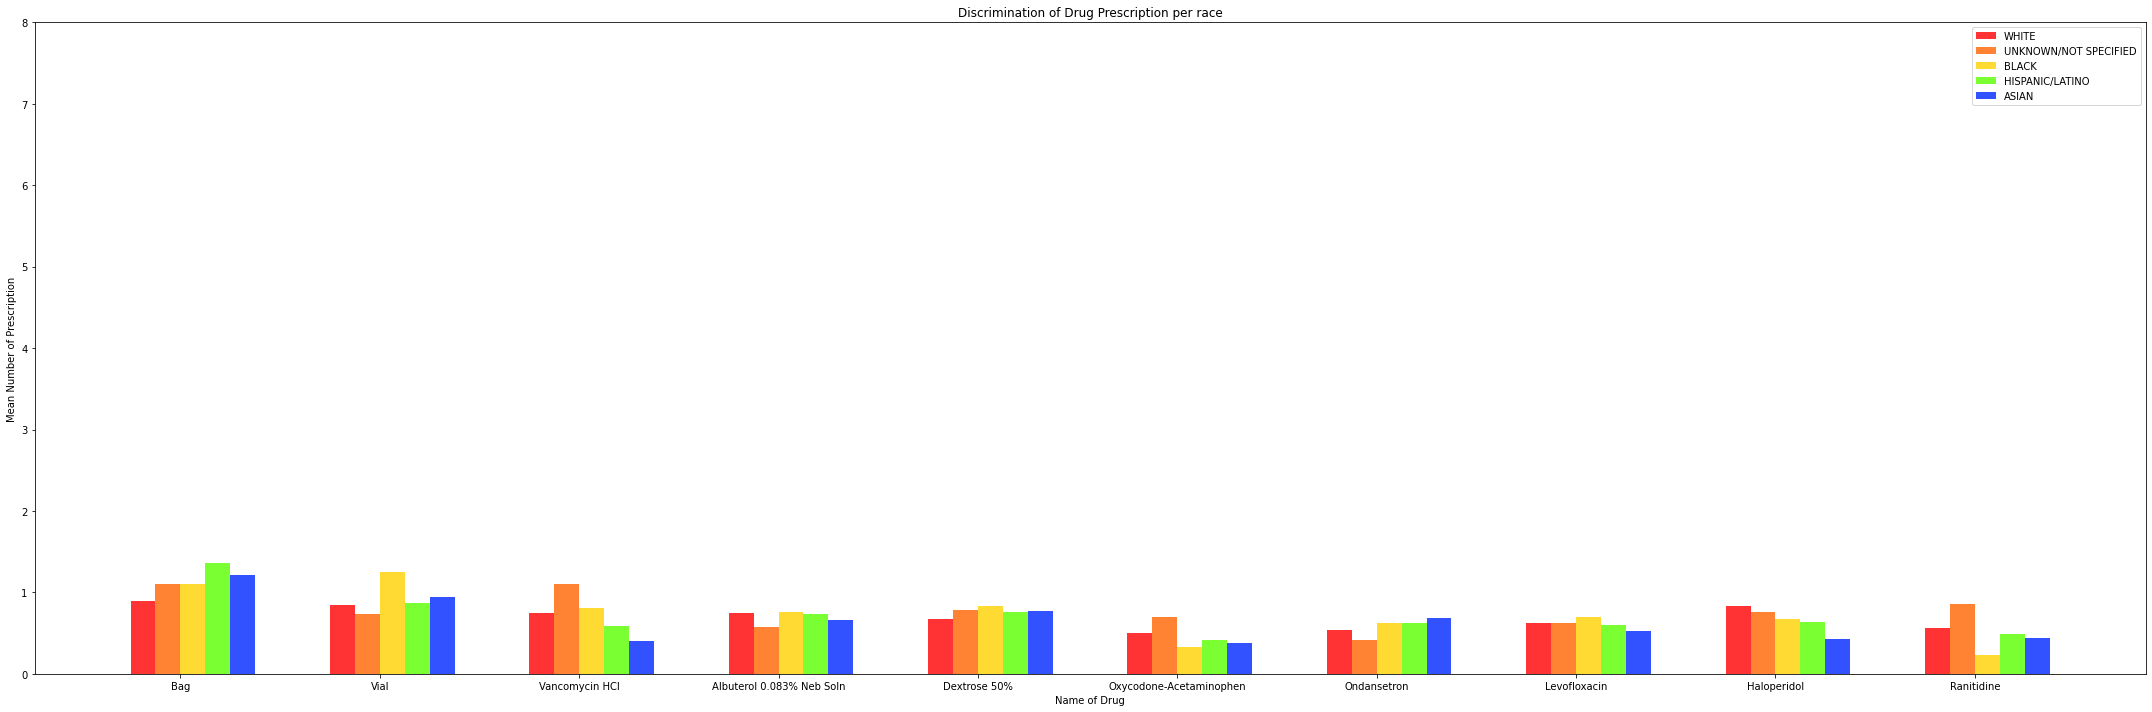

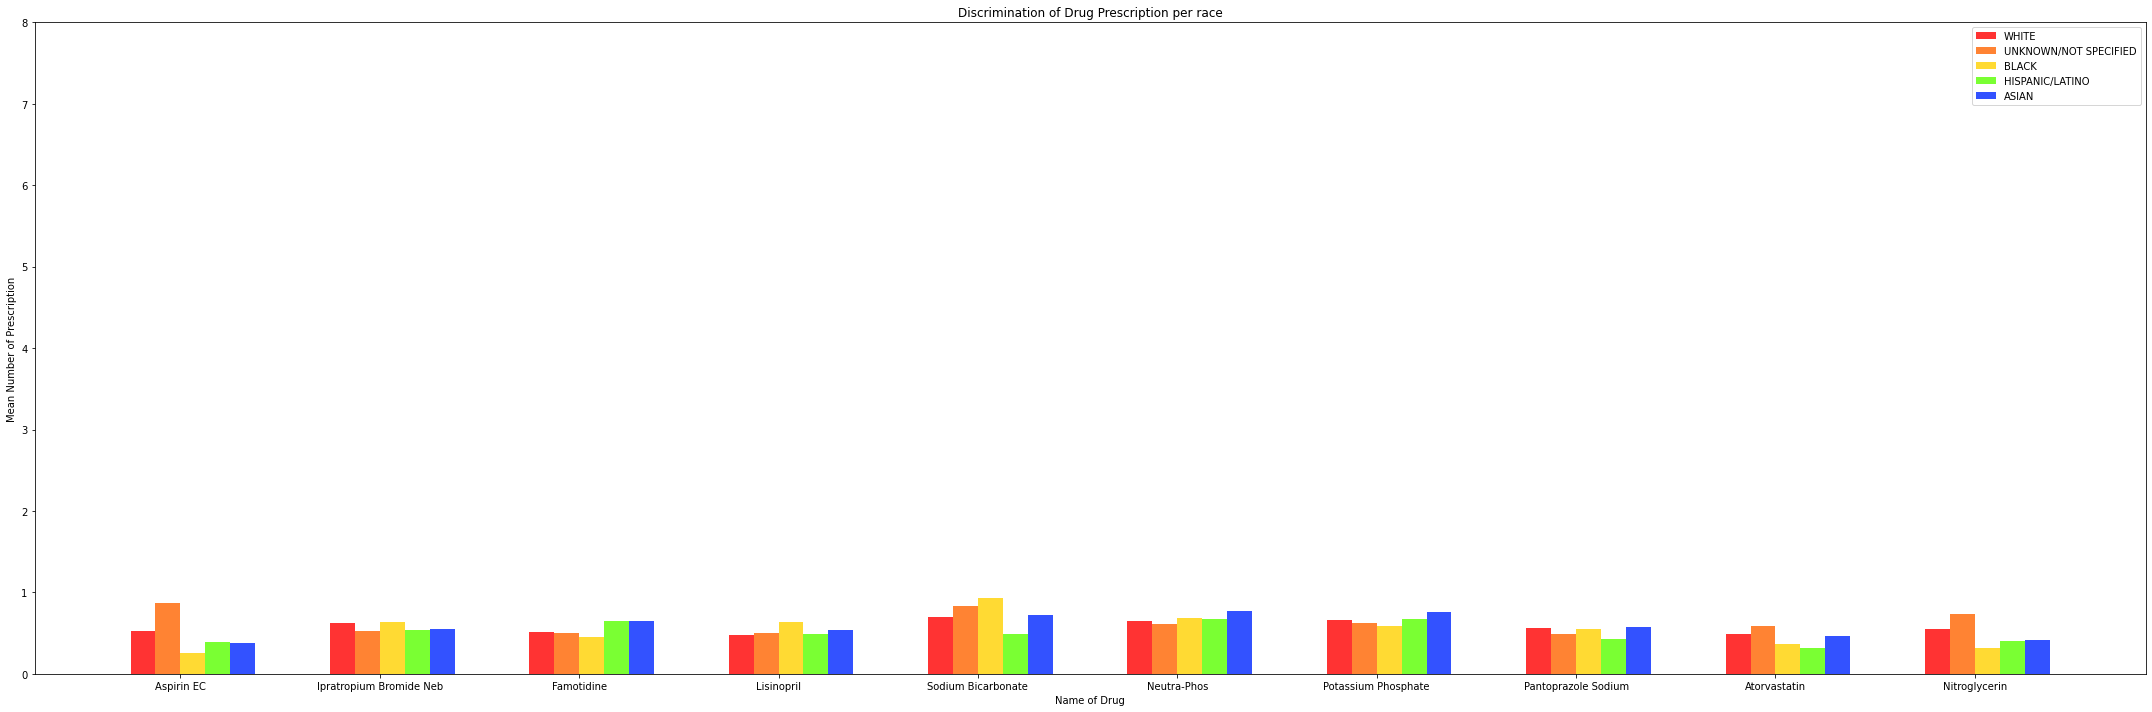

In [ ]:
tmp = []

for drug in final_df:
  if drug != 'ETHNICITY':
    tmp.append(list(final_df[drug]))

for i in range(10, len(tmp)+1, 10):
  data = np.array(tmp[i-10:i])

  length = len(data)
  x_labels = top_drug[i-10:i]

  fig, ax = plt.subplots(figsize=(30, 10))
  width = 1.0
  x = np.arange(0, length*8, 8)

  ax.bar(x, data[:,0], width, color='#FF3333', label='WHITE')
  ax.bar(x + width, data[:,1], width, color='#FF8333', label='UNKNOWN/NOT SPECIFIED')
  ax.bar(x + (2 * width), data[:,2], width, color='#FFDA33', label='BLACK')
  ax.bar(x + (3 * width), data[:,3], width, color='#7AFF33', label='HISPANIC/LATINO')
  ax.bar(x + (4 * width), data[:,4], width, color='#3352FF', label='ASIAN')

  ax.set_ylabel('Mean Number of Prescription')
  ax.set_ylim(0,8)
  ax.set_xticks(x + width + width/2)
  ax.set_xticklabels(x_labels)
  ax.set_xlabel('Name of Drug')
  ax.set_title('Discrimination of Drug Prescription per race')
  ax.legend()

  fig.tight_layout()
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


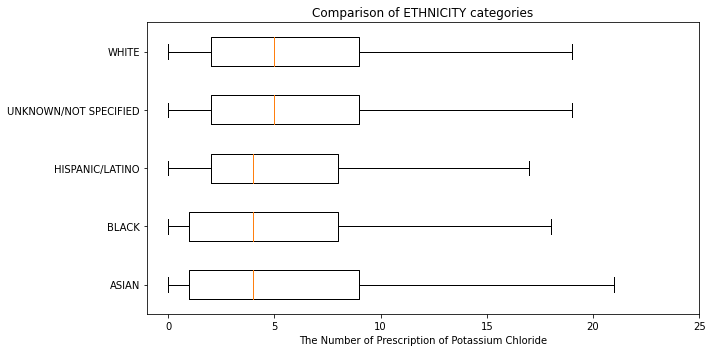

                     df        sum_sq       mean_sq          F         PR(>F)
C(ETHNICITY)        4.0  7.866801e+04  19667.003127  259.04401  6.528659e-223
Residual      1133854.0  8.608387e+07     75.921474        NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


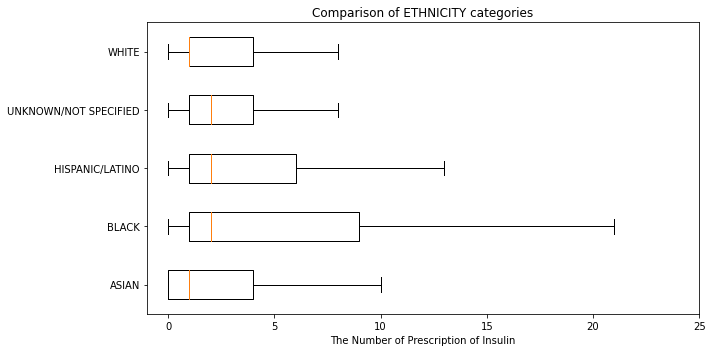

                     df        sum_sq        mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  6.839123e+05  170978.077932  1432.06696     0.0
Residual      1133854.0  1.353737e+08     119.392516         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


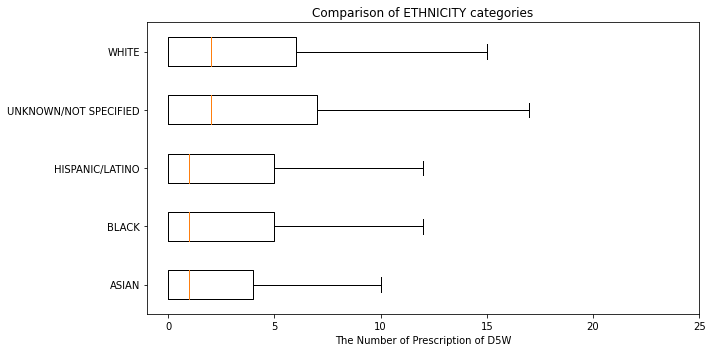

                     df        sum_sq       mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  3.343095e+05  83577.368452  808.838347     0.0
Residual      1133854.0  1.171613e+08    103.330126         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


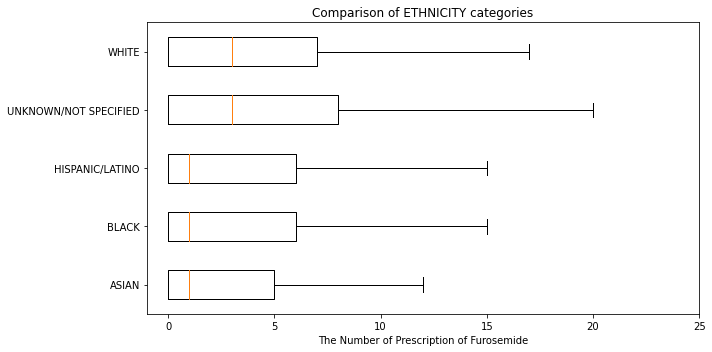

                     df        sum_sq       mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  2.031363e+05  50784.083515  893.960358     0.0
Residual      1133854.0  6.441196e+07     56.807982         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


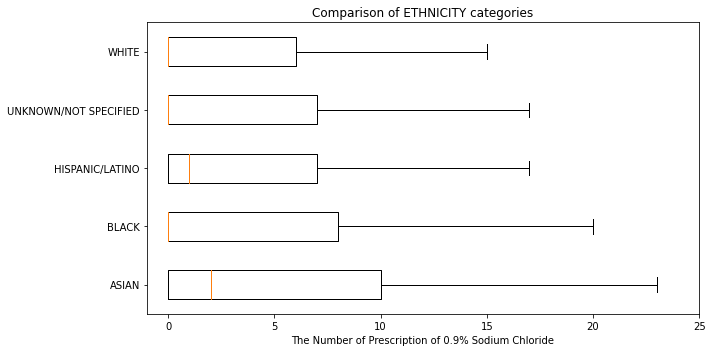

                     df        sum_sq       mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  2.666488e+05  66662.211078  722.860674     0.0
Residual      1133854.0  1.045640e+08     92.220000         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


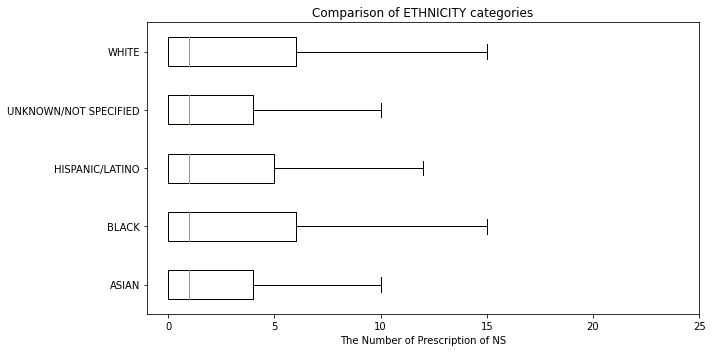

                     df        sum_sq       mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  1.040602e+05  26015.039852  381.351404     0.0
Residual      1133854.0  7.734928e+07     68.218026         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


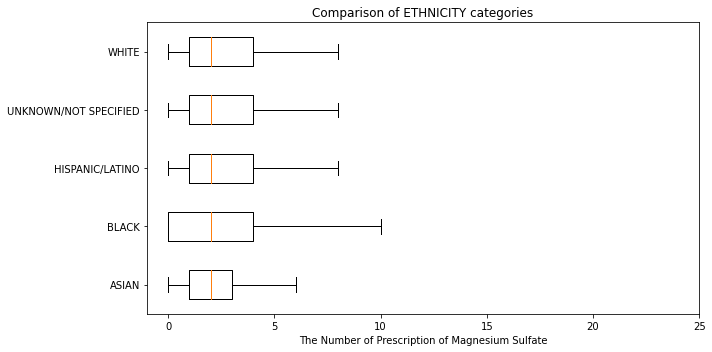

                     df        sum_sq      mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  1.243430e+04  3108.575685  230.381592  4.349425e-198
Residual      1133854.0  1.529927e+07    13.493160         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


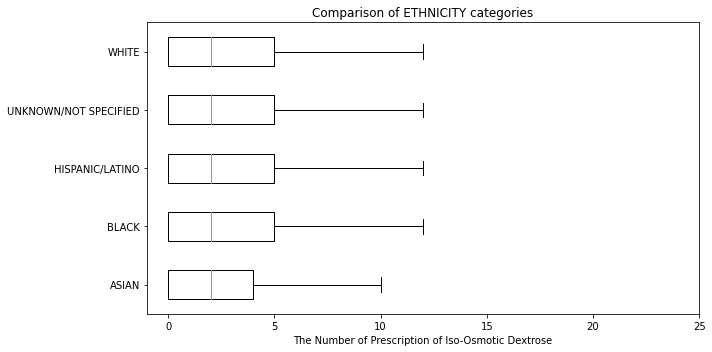

                     df        sum_sq      mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  1.609131e+04  4022.828411  246.380855  6.058980e-212
Residual      1133854.0  1.851321e+07    16.327683         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


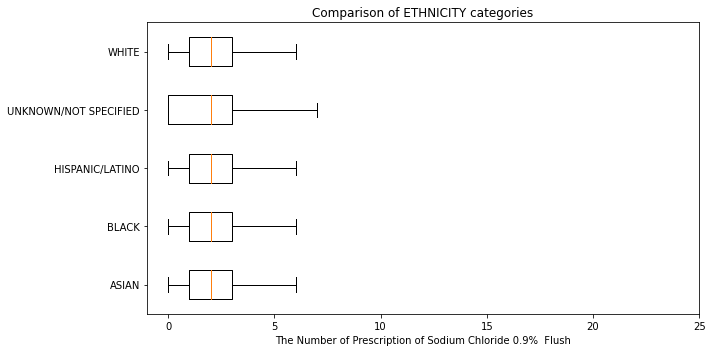

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  8.810698e+03  2202.674621  642.927987     0.0
Residual      1133854.0  3.884590e+06     3.426005         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


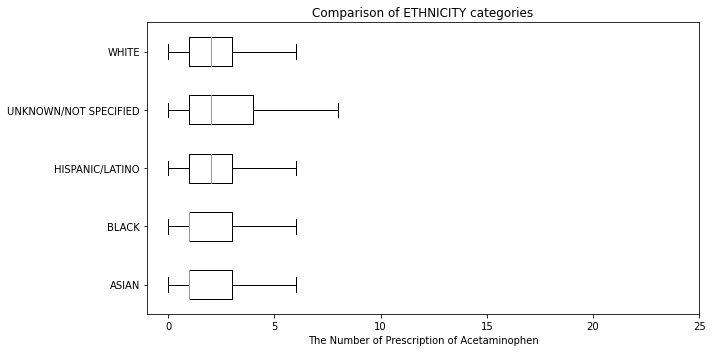

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  1.121739e+04  2804.348609  581.546317     0.0
Residual      1133854.0  5.467702e+06     4.822227         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


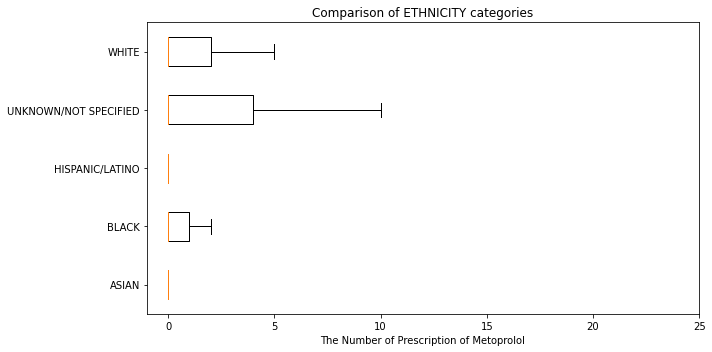

                     df        sum_sq       mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  1.086773e+05  27169.313308  1008.756339     0.0
Residual      1133854.0  3.053863e+07     26.933475          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


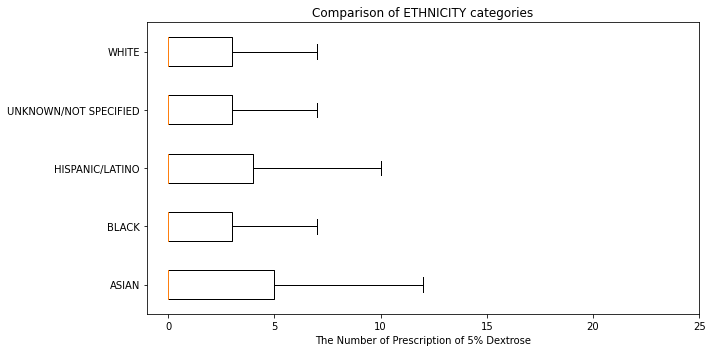

                     df        sum_sq       mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  8.013057e+04  20032.642789  376.792712     0.0
Residual      1133854.0  6.028273e+07     53.166216         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


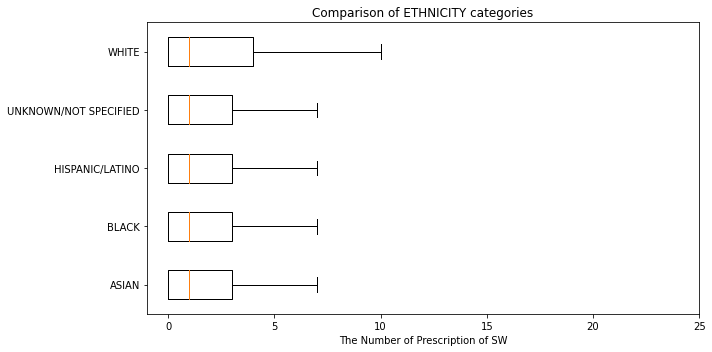

                     df        sum_sq       mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  5.882197e+04  14705.493333  647.367729     0.0
Residual      1133854.0  2.575643e+07     22.715827         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


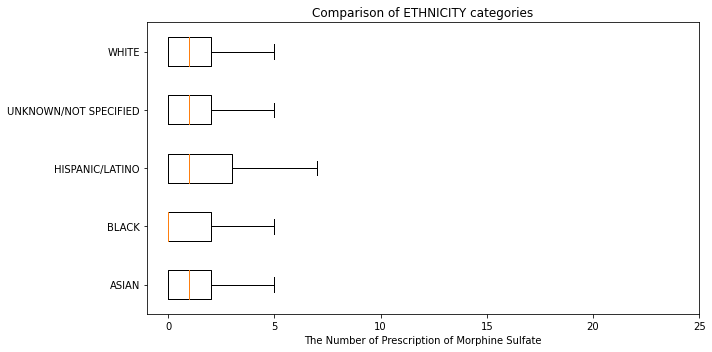

                     df        sum_sq      mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  7.661601e+03  1915.400235  252.867468  1.460190e-217
Residual      1133854.0  8.588626e+06     7.574720         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


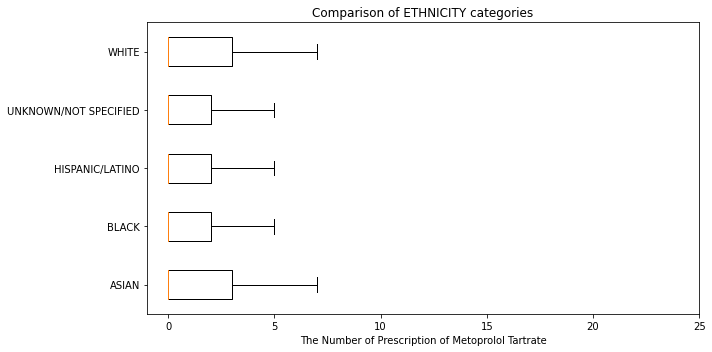

                     df        sum_sq       mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  4.973379e+04  12433.447865  602.372642     0.0
Residual      1133854.0  2.340364e+07     20.640791         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


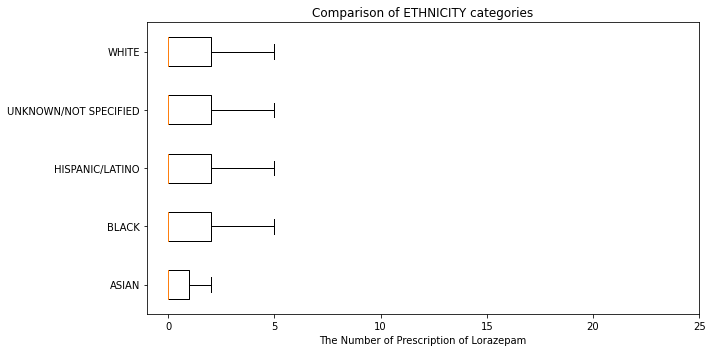

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  2.737818e+04  6844.544059  597.981853     0.0
Residual      1133854.0  1.297818e+07    11.446073         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


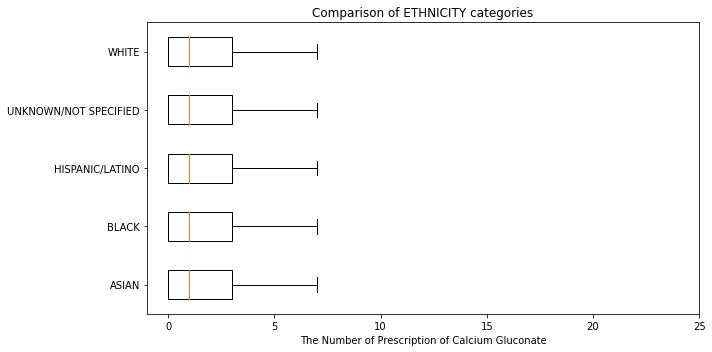

                     df        sum_sq      mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  1.367760e+04  3419.398762  244.308857  3.774860e-210
Residual      1133854.0  1.586966e+07    13.996213         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


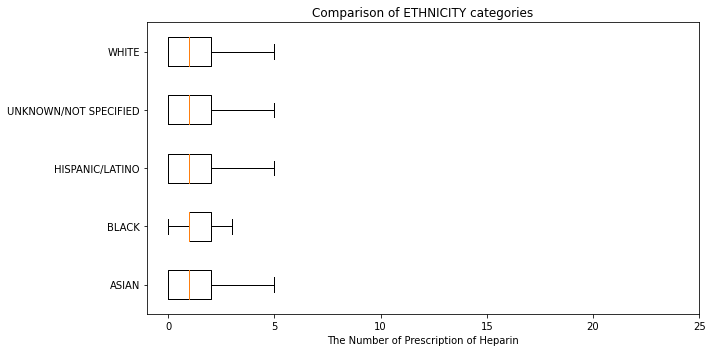

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  1.671477e+04  4178.691927  1429.268961     0.0
Residual      1133854.0  3.315000e+06     2.923657          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


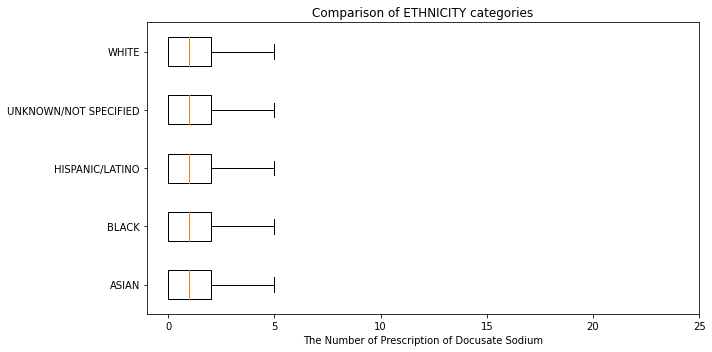

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  6.185139e+03  1546.284788  1033.578085     0.0
Residual      1133854.0  1.696303e+06     1.496050          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


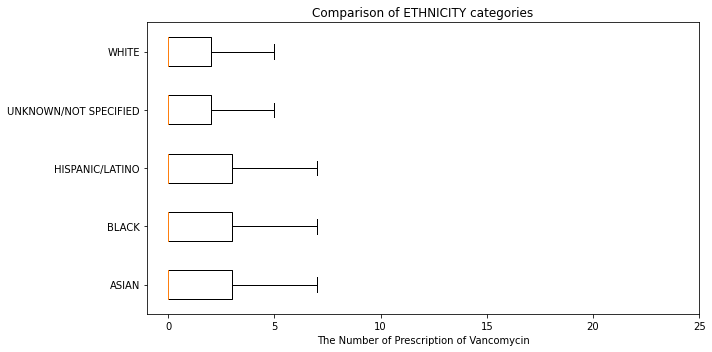

                     df        sum_sq      mean_sq         F         PR(>F)
C(ETHNICITY)        4.0  1.265759e+04  3164.397283  305.2229  6.535498e-263
Residual      1133854.0  1.175523e+07    10.367496       NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


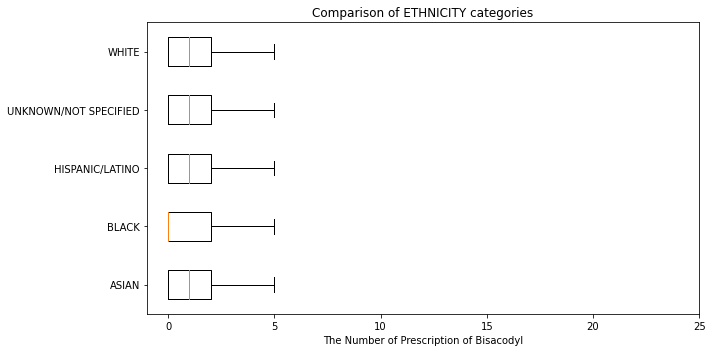

                     df        sum_sq     mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  1.333347e+03  333.336798  155.207358  5.231159e-133
Residual      1133854.0  2.435163e+06    2.147687         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


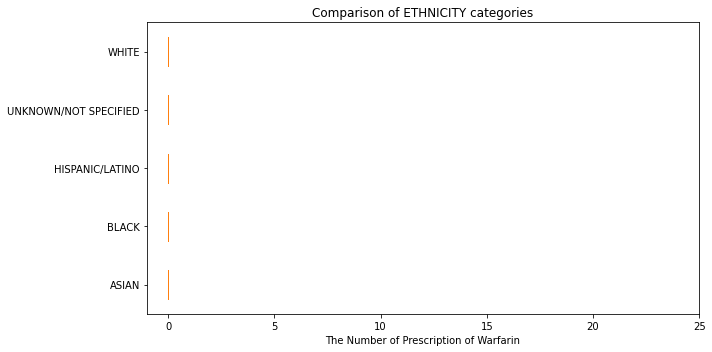

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  2.473839e+04  6184.598176  420.156736     0.0
Residual      1133854.0  1.669004e+07    14.719741         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


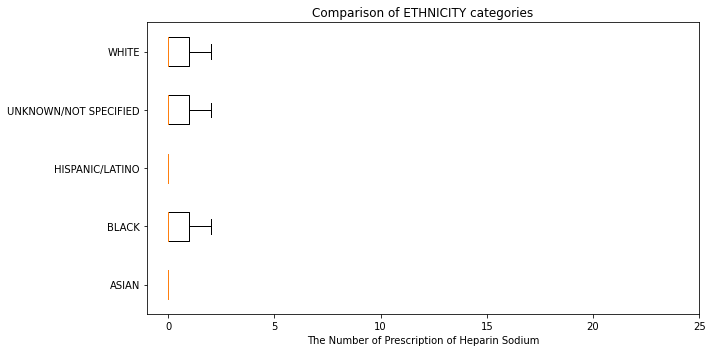

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  2.562154e+04  6405.384418  546.999077     0.0
Residual      1133854.0  1.327748e+07    11.710046         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


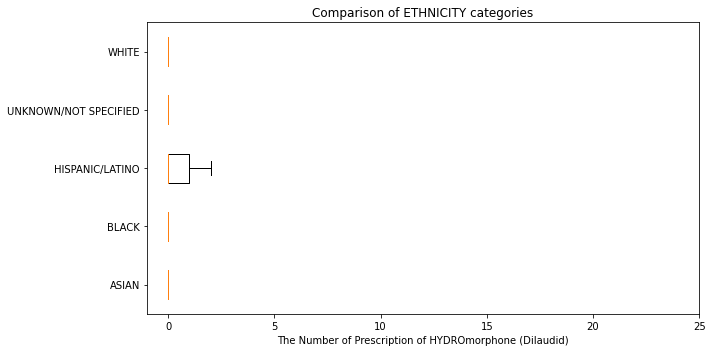

                     df        sum_sq      mean_sq          F  PR(>F)
C(ETHNICITY)        4.0  2.961864e+04  7404.660568  581.92081     0.0
Residual      1133854.0  1.442774e+07    12.724516        NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


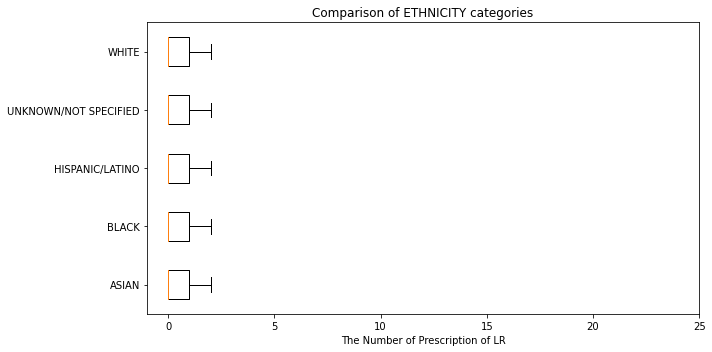

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  2.951407e+04  7378.518364  702.642029     0.0
Residual      1133854.0  1.190672e+07    10.501106         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


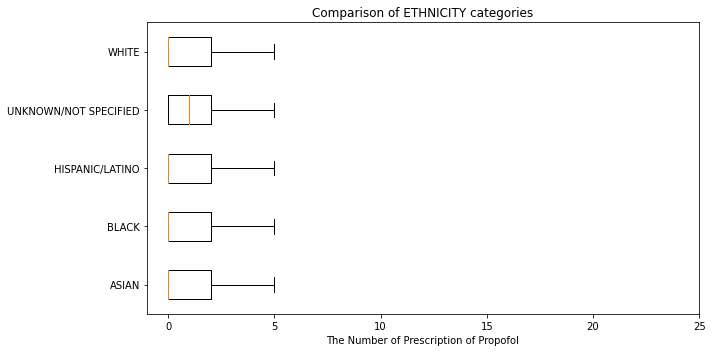

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  1.274175e+04  3185.438322  695.750723     0.0
Residual      1133854.0  5.191259e+06     4.578419         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


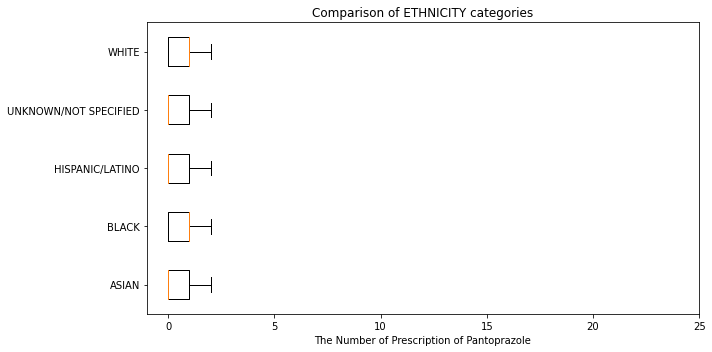

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  4.392034e+03  1098.008510  465.995322     0.0
Residual      1133854.0  2.671661e+06     2.356265         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


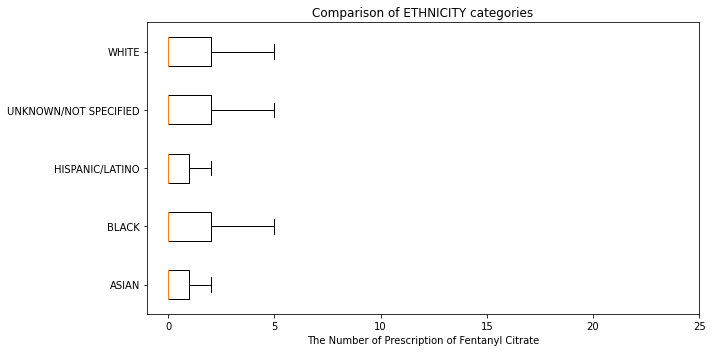

                     df        sum_sq     mean_sq        F         PR(>F)
C(ETHNICITY)        4.0  3.497118e+03  874.279500  128.443  7.452950e-110
Residual      1133854.0  7.717862e+06    6.806751      NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


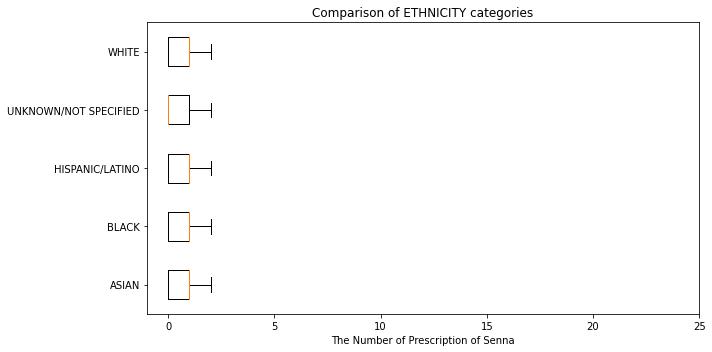

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  4.107285e+03  1026.821343  1044.988001     0.0
Residual      1133854.0  1.114142e+06     0.982615          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


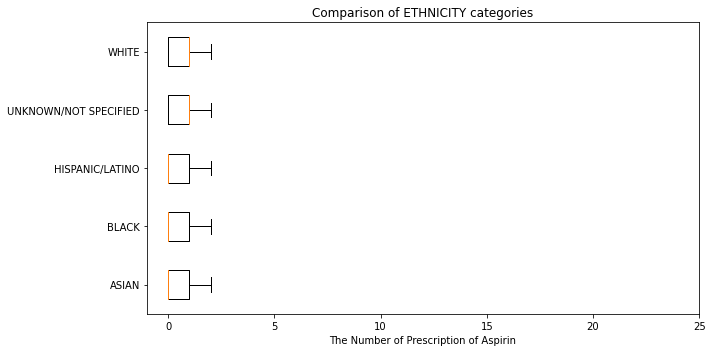

                     df        sum_sq     mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  1.471620e+03  367.905048  304.801311  1.515214e-262
Residual      1133854.0  1.368598e+06    1.207032         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


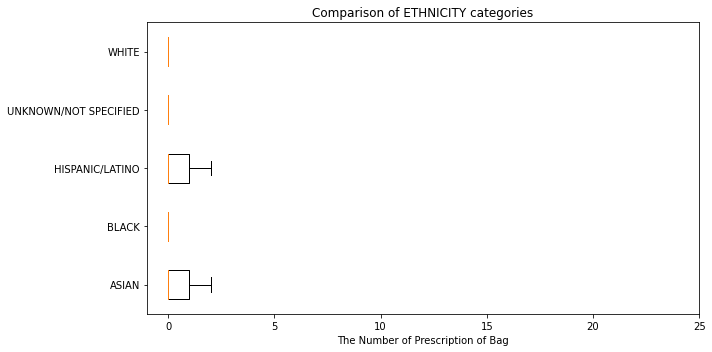

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  1.713484e+04  4283.710242  574.513436     0.0
Residual      1133854.0  8.454288e+06     7.456240         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


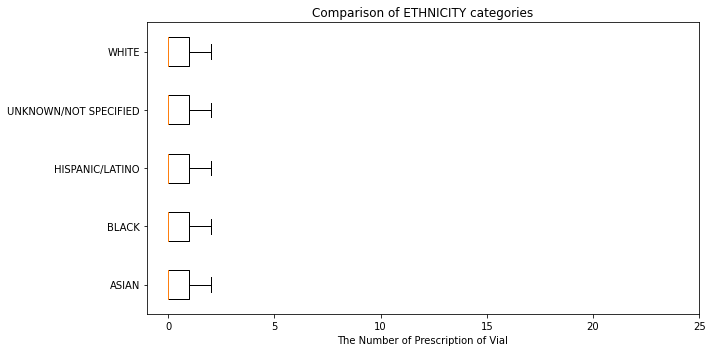

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  2.006686e+04  5016.714983  1654.521127     0.0
Residual      1133854.0  3.437987e+06     3.032125          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


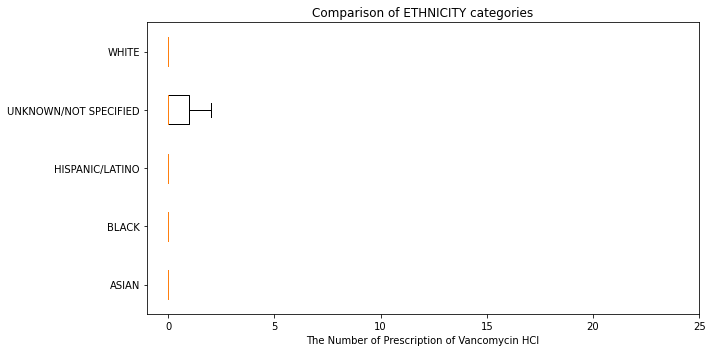

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  1.985008e+04  4962.519979  995.853982     0.0
Residual      1133854.0  5.650199e+06     4.983180         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


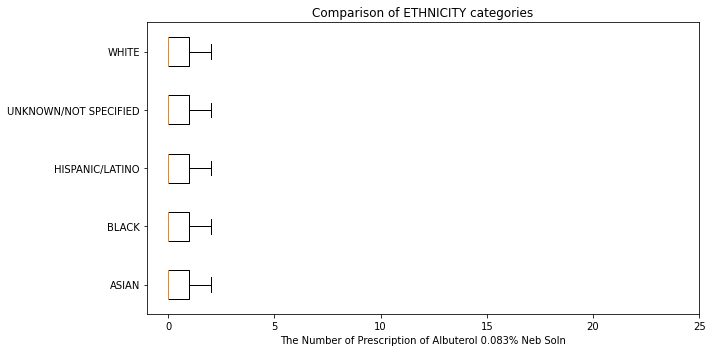

                     df        sum_sq     mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  3.160079e+03  790.019725  464.741475     0.0
Residual      1133854.0  1.927452e+06    1.699912         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


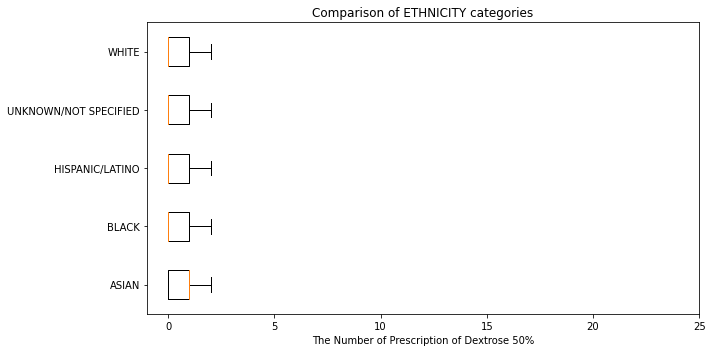

                     df        sum_sq     mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  3.915851e+03  978.962819  790.464717     0.0
Residual      1133854.0  1.404238e+06    1.238465         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


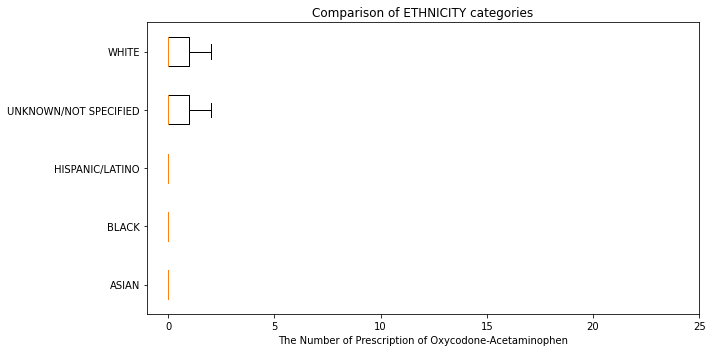

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  9.431349e+03  2357.837218  2616.188263     0.0
Residual      1133854.0  1.021885e+06     0.901249          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


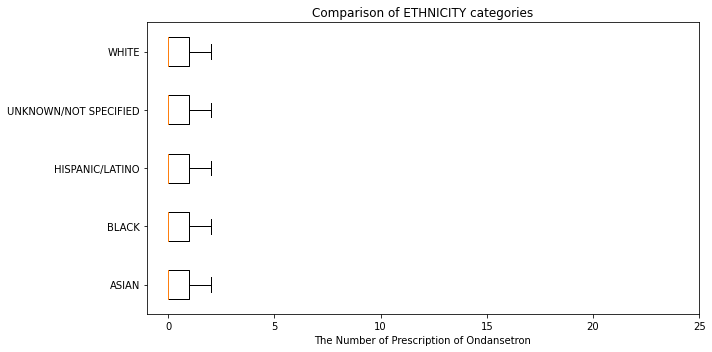

                     df        sum_sq     mean_sq          F  PR(>F)
C(ETHNICITY)        4.0  3.542539e+03  885.634658  725.58773     0.0
Residual      1133854.0  1.383954e+06    1.220576        NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


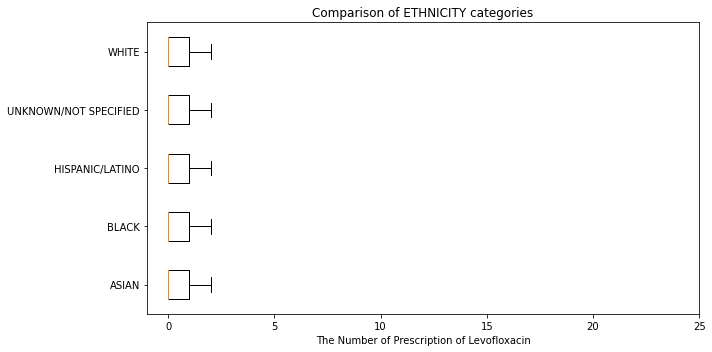

                     df        sum_sq     mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  9.298030e+02  232.450758  145.022566  3.395866e-124
Residual      1133854.0  1.817408e+06    1.602859         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


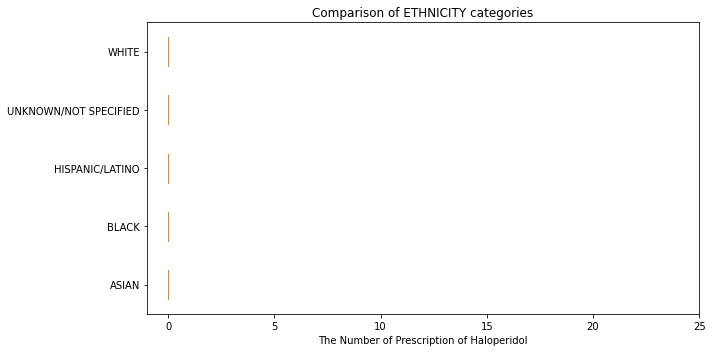

                     df        sum_sq     mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  8.517310e+03  2129.32754  369.458091  1.480290e-318
Residual      1133854.0  6.534832e+06     5.76338         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


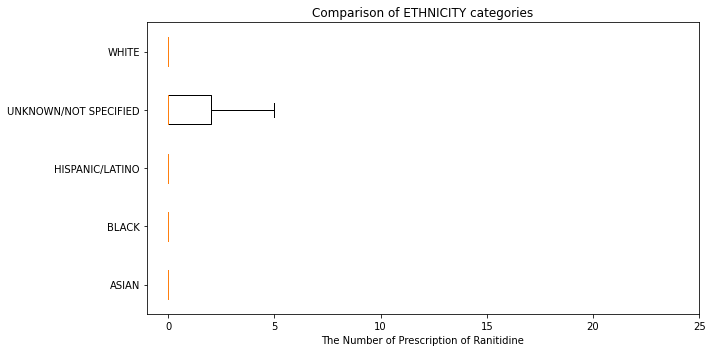

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  2.473906e+04  6184.765909  4371.925807     0.0
Residual      1133854.0  1.604012e+06     1.414655          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


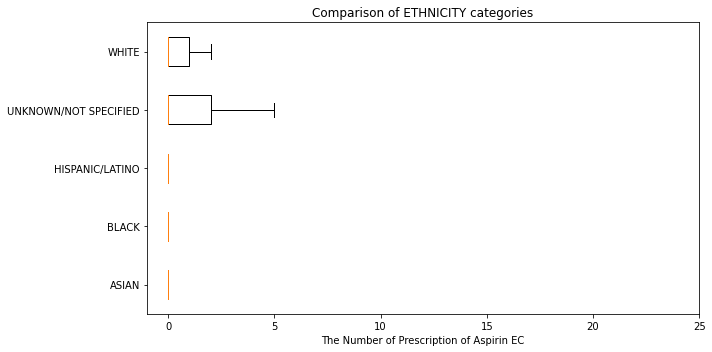

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  2.470053e+04  6175.133180  6198.838189     0.0
Residual      1133854.0  1.129518e+06     0.996176          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


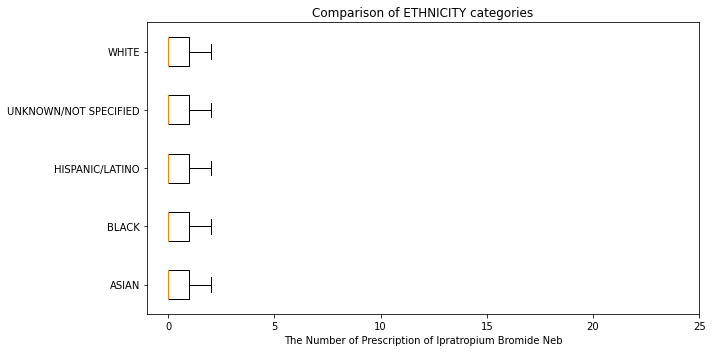

                     df        sum_sq     mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  1.304959e+03  326.239732  277.441305  7.585044e-239
Residual      1133854.0  1.333285e+06    1.175887         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


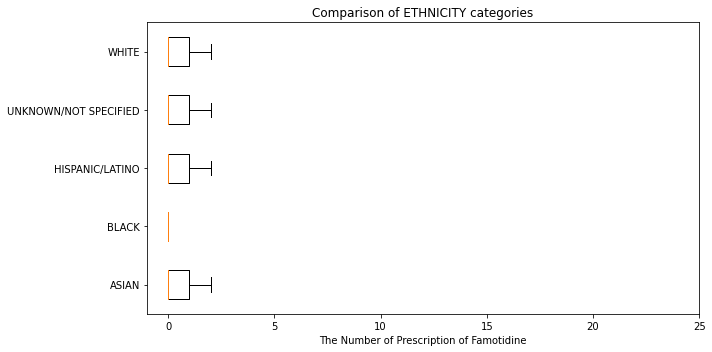

                     df        sum_sq     mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  1.706509e+03  426.627257  402.332959     0.0
Residual      1133854.0  1.202320e+06    1.060384         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


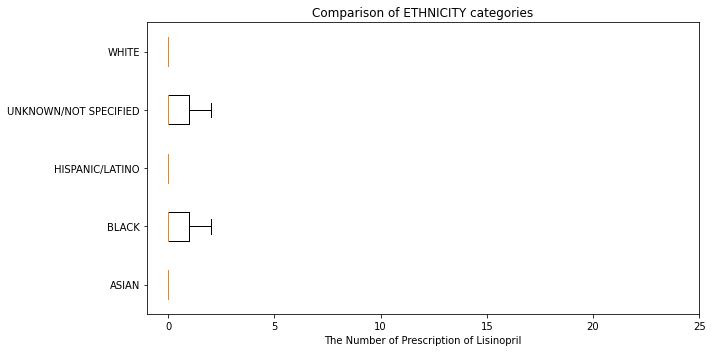

                     df        sum_sq     mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  2.708035e+03  677.008672  491.557783     0.0
Residual      1133854.0  1.561625e+06    1.377272         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


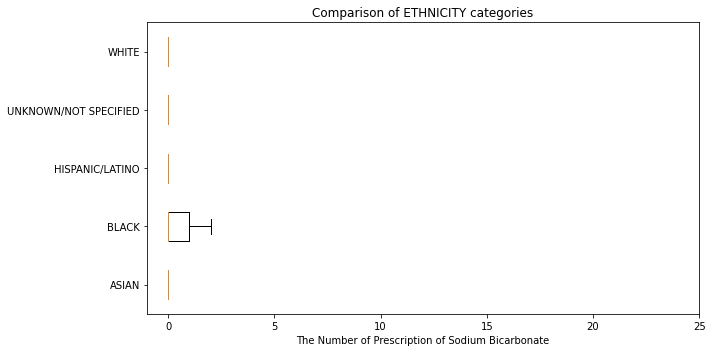

                     df        sum_sq      mean_sq           F  PR(>F)
C(ETHNICITY)        4.0  9.582624e+03  2395.655971  482.485244     0.0
Residual      1133854.0  5.629859e+06     4.965242         NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


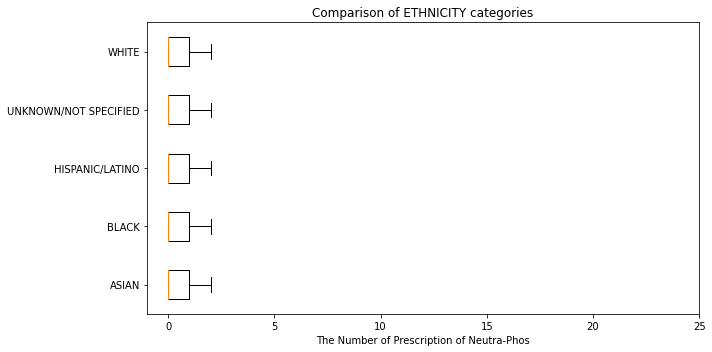

                     df        sum_sq     mean_sq          F        PR(>F)
C(ETHNICITY)        4.0  7.480136e+02  187.003396  86.464398  1.411464e-73
Residual      1133854.0  2.452276e+06    2.162779        NaN           NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


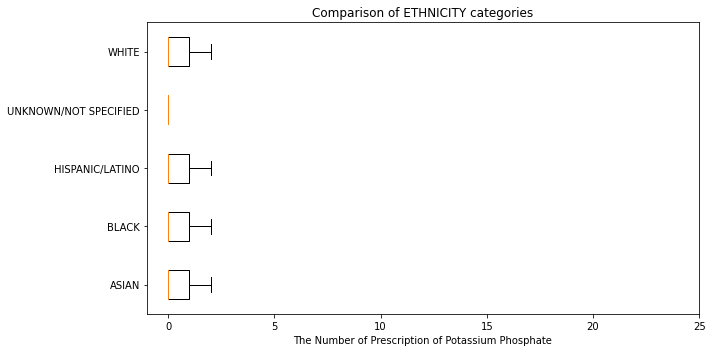

                     df        sum_sq     mean_sq           F         PR(>F)
C(ETHNICITY)        4.0  1.012176e+03  253.044065  126.920917  1.543983e-108
Residual      1133854.0  2.260581e+06    1.993714         NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


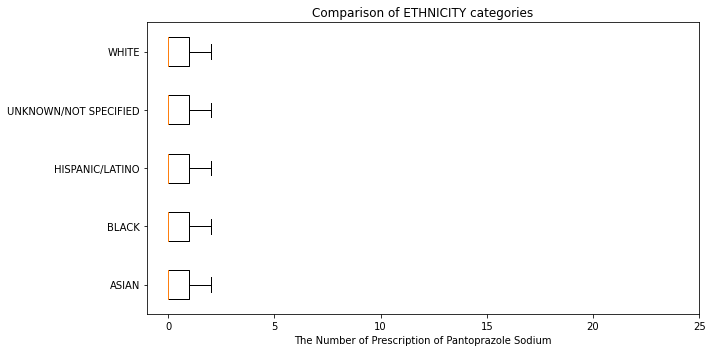

                     df        sum_sq     mean_sq          F         PR(>F)
C(ETHNICITY)        4.0  1.086179e+03  271.544768  251.87138  1.064441e-216
Residual      1133854.0  1.222418e+06    1.078109        NaN            NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


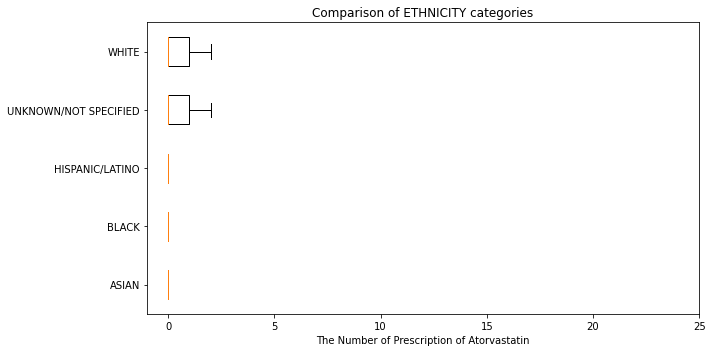

                     df         sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0    4066.661594  1016.665398  1285.059379     0.0
Residual      1133854.0  897040.360607     0.791143          NaN     NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


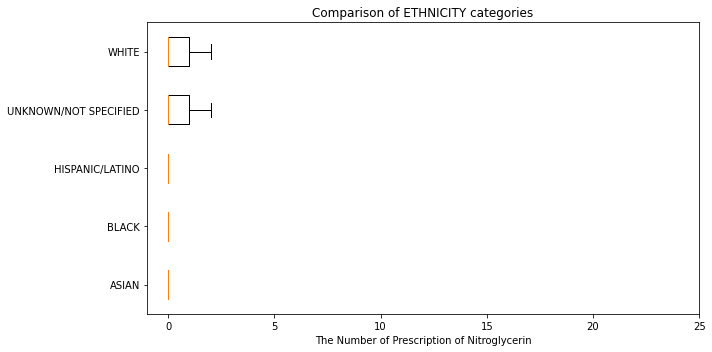

                     df        sum_sq      mean_sq            F  PR(>F)
C(ETHNICITY)        4.0  1.184149e+04  2960.371769  2320.947335     0.0
Residual      1133854.0  1.446232e+06     1.275501          NaN     NaN


In [ ]:
for drug in top_drug:
  result = adm_pres_df[['ETHNICITY', drug]].groupby('ETHNICITY').mean().reset_index()

  categories = result['ETHNICITY'].values.tolist()

  hist_data = []
  for cat in categories:
    hist_data.append(adm_pres_df.loc[adm_pres_df['ETHNICITY'] == cat, drug].values)

  fig, ax = plt.subplots(figsize=(10,5))
  ax.boxplot(hist_data, showfliers=False, vert=False)
  ax.set_xlim((-1, 25))
  ax.set_yticklabels(categories)
  ax.set_xlabel('The Number of Prescription of {}'.format(drug))
  #ax.tick_params(left=False, right=False) 
  ax.set_title('Comparison of {} categories'.format('ETHNICITY'))
  plt.tight_layout()
  plt.show();

  tmp_anova = adm_pres_df[['ETHNICITY', drug]]
  tmp_anova.columns = ['ETHNICITY', 'DRUG']

  model = ols('DRUG ~ C(ETHNICITY)', tmp_anova).fit()
  table = anova_lm(model)
  print(table)

In [ ]:
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'WHITE']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'UNKNOWN/NOT SPECIFIED']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'BLACK']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'HISPANIC/LATINO']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'ASIAN']))

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.6962192058563232, 0.0)
(0.689491868019104, 0.0)
(0.6605608463287354, 0.0)
(0.7226751446723938, 0.0)
(0.7759308815002441, 0.0)


In [ ]:
comp = MultiComparison(tmp_anova.DRUG, tmp_anova.ETHNICITY)
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
ASIAN,BLACK,-3.2505,0.0012,0.0115,True
ASIAN,HISPANIC/LATINO,-1.2746,0.2025,1.0,False
ASIAN,UNKNOWN/NOT SPECIFIED,-20.3778,0.0,0.0,True
ASIAN,WHITE,-15.9508,0.0,0.0,True
BLACK,HISPANIC/LATINO,2.2623,0.0237,0.2368,False
BLACK,UNKNOWN/NOT SPECIFIED,-25.6873,0.0,0.0,True
BLACK,WHITE,-23.2063,0.0,0.0,True
HISPANIC/LATINO,UNKNOWN/NOT SPECIFIED,-21.9127,0.0,0.0,True
HISPANIC/LATINO,WHITE,-17.3653,0.0,0.0,True
UNKNOWN/NOT SPECIFIED,WHITE,11.3496,0.0,0.0,True


In [ ]:
hsd = pairwise_tukeyhsd(tmp_anova['DRUG'], tmp_anova['ETHNICITY'], alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
ASIAN,BLACK,0.17,0.0079,0.0305,0.3095,True
ASIAN,HISPANIC/LATINO,0.0675,0.7602,-0.0945,0.2296,False
ASIAN,UNKNOWN/NOT SPECIFIED,1.0072,0.001,0.8687,1.1457,True
ASIAN,WHITE,0.7394,0.001,0.6124,0.8664,True
BLACK,HISPANIC/LATINO,-0.1025,0.139,-0.223,0.0181,False
BLACK,UNKNOWN/NOT SPECIFIED,0.8372,0.001,0.7508,0.9235,True
BLACK,WHITE,0.5694,0.001,0.503,0.6358,True
HISPANIC/LATINO,UNKNOWN/NOT SPECIFIED,0.9396,0.001,0.8202,1.0591,True
HISPANIC/LATINO,WHITE,0.6718,0.001,0.5659,0.7778,True
UNKNOWN/NOT SPECIFIED,WHITE,-0.2678,0.001,-0.3322,-0.2034,True


## Data Pre-Processing

In [ ]:
nan_cols = [i for i in adm_pres_df.columns if adm_pres_df[i].isnull().any()]
print(nan_cols)

['MARITAL_STATUS']


In [ ]:
dt = adm_pres_df.copy()
print(dt.shape)
dt.head()

(1133859, 57)


,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin
0,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
1,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
2,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
3,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
4,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0


WHITE: 821184 | UNKNOWN/NOT SPECIFIED: 125180 | BLACK: 116837 | HISPANIC/LATINO: 42012 | ASIAN: 28646


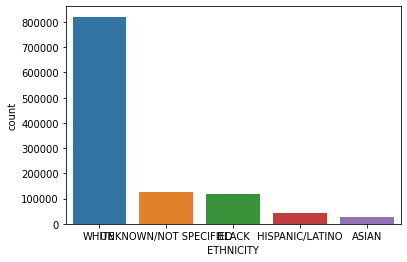

In [ ]:
training_set = dt.copy()

print('WHITE: {} | UNKNOWN/NOT SPECIFIED: {} | BLACK: {} | HISPANIC/LATINO: {} | ASIAN: {}'.format(len(training_set[training_set['ETHNICITY']=='WHITE']),\
                                         len(training_set[training_set['ETHNICITY']=='UNKNOWN/NOT SPECIFIED']),
                                         len(training_set[training_set['ETHNICITY']=='BLACK']),
                                         len(training_set[training_set['ETHNICITY']=='HISPANIC/LATINO']),
                                         len(training_set[training_set['ETHNICITY']=='ASIAN'])))

sns.countplot(x='ETHNICITY', data=training_set)

In [ ]:
white_yes = dt.loc[dt['ETHNICITY'] == 'WHITE']
white_yes

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin
0,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
1,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
2,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
3,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
4,23,152223,ELECTIVE,Medicare,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,0,3,0,1,2,1,0,1,1,4,0,2,0,0,4,0,0,0,0,1,0,0,1,0,0,0,1,5,0,2,3,0,2,0,2,0,0,4,0,2,3,1,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133854,98813,190264,EMERGENCY,Private,MARRIED,WHITE,INTRACRANIAL HEMORRHAGE,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1133855,98813,190264,EMERGENCY,Private,MARRIED,WHITE,INTRACRANIAL HEMORRHAGE,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1133856,98813,190264,EMERGENCY,Private,MARRIED,WHITE,INTRACRANIAL HEMORRHAGE,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1133857,98813,190264,EMERGENCY,Private,MARRIED,WHITE,INTRACRANIAL HEMORRHAGE,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0


In [ ]:
white_no = dt.loc[dt['ETHNICITY'] != 'WHITE']
white_no

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin
189,30,104557,EMERGENCY,Medicare,MARRIED,UNKNOWN/NOT SPECIFIED,UNSTABLE ANGINA\CATH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318,39,106266,NEWBORN,Private,NaN,UNKNOWN/NOT SPECIFIED,NEWBORN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1077,361,108205,EMERGENCY,Medicare,MARRIED,UNKNOWN/NOT SPECIFIED,HYPOTENSION,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,0,0,1,0,0,3,0,0,0,0,0
1078,361,108205,EMERGENCY,Medicare,MARRIED,UNKNOWN/NOT SPECIFIED,HYPOTENSION,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,0,0,1,0,0,3,0,0,0,0,0
1079,361,108205,EMERGENCY,Medicare,MARRIED,UNKNOWN/NOT SPECIFIED,HYPOTENSION,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,0,0,1,0,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133510,98749,158912,EMERGENCY,Medicaid,SINGLE,BLACK,DIABETIC KETOACIDOSIS,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,9,0,0,5,0,0,0,1,0,0,0,0,4,0,0,0,0,0,7,4,0,0,0,0,0,1,0,0,0,0
1133511,98749,158912,EMERGENCY,Medicaid,SINGLE,BLACK,DIABETIC KETOACIDOSIS,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,9,0,0,5,0,0,0,1,0,0,0,0,4,0,0,0,0,0,7,4,0,0,0,0,0,1,0,0,0,0
1133512,98749,158912,EMERGENCY,Medicaid,SINGLE,BLACK,DIABETIC KETOACIDOSIS,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,9,0,0,5,0,0,0,1,0,0,0,0,4,0,0,0,0,0,7,4,0,0,0,0,0,1,0,0,0,0
1133513,98749,158912,EMERGENCY,Medicaid,SINGLE,BLACK,DIABETIC KETOACIDOSIS,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,9,0,0,5,0,0,0,1,0,0,0,0,4,0,0,0,0,0,7,4,0,0,0,0,0,1,0,0,0,0


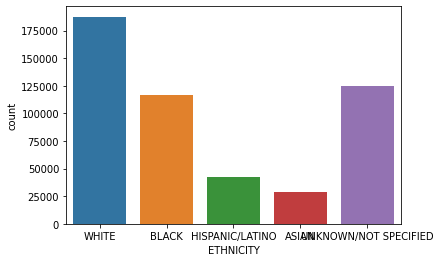

In [ ]:
# Oversample the minority class by using SMOTE
white_yes = dt.loc[dt['ETHNICITY'] == 'WHITE']
white_no = dt.loc[(dt['ETHNICITY'] == 'BLACK') | (dt['ETHNICITY'] == 'HISPANIC/LATINO') | (dt['ETHNICITY'] == 'ASIAN')]

white_yes_undersample = resample(
    white_yes,
    replace = False,
    n_samples = len(white_no),
    random_state=42
)

#pd.concat([white_no, dt.loc[dt['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED']], axis=0)
undersample = pd.concat([white_yes_undersample, pd.concat([white_no, dt.loc[dt['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED']], axis=0)], axis=0)
#print('Stroke: {} | No Stroke: {}'.format(len(training_set_resampled[training_set_resampled['stroke']==1]),\
#                                          len(training_set_resampled[training_set_resampled['stroke']==0])))

sns.countplot(x='ETHNICITY', data=undersample)

In [ ]:
dt = undersample.copy()

### One-Hot Encoding: ETHNICITY

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['ETHNICITY'], prefix='ETHNICITY')], axis=1).drop(['ETHNICITY'], axis=1)
dt.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,DIAGNOSIS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin,ETHNICITY_ASIAN,ETHNICITY_BLACK,ETHNICITY_HISPANIC/LATINO,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE
810379,62181,134053,EMERGENCY,Private,SINGLE,BLUNT TRAUMA,21,4,3,0,0,0,0,7,4,7,0,2,1,1,4,0,12,1,1,0,2,0,2,5,0,0,0,7,0,0,2,0,0,0,1,0,0,0,12,0,6,0,2,1,0,3,0,0,0,0,0,0,0,0,1
623472,29872,177175,EMERGENCY,Medicare,SINGLE,PNEUMONIA,17,11,1,0,0,1,1,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,6,2,0,0,0,3,0,0,1,1,5,0,0,0,0,2,7,3,0,0,8,0,2,2,6,0,2,0,0,0,0,0,1
602426,31030,126060,EMERGENCY,Medicare,MARRIED,PNEUMONIA,0,0,1,0,0,0,0,0,0,4,30,0,0,0,12,22,0,3,0,0,1,0,7,0,3,0,0,10,0,0,3,34,0,0,0,0,0,1,22,0,6,0,27,0,2,0,6,0,1,0,0,0,0,0,1
1070015,92528,110863,EMERGENCY,Medicare,MARRIED,WEAKNESS,0,5,0,2,1,0,0,0,0,0,0,0,0,0,0,5,0,1,1,0,0,1,2,0,0,0,1,0,0,4,6,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,1
134725,7831,117035,EMERGENCY,Medicare,SINGLE,ANEMIA,0,0,0,0,0,0,0,0,2,0,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,3,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,1


### One-Hot Encoding: ADMISSION_TYPE

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['ADMISSION_TYPE'], prefix='ADMISSION_TYPE')], axis=1).drop(['ADMISSION_TYPE'], axis=1)
dt.head()

,SUBJECT_ID,HADM_ID,INSURANCE,MARITAL_STATUS,DIAGNOSIS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin,ETHNICITY_ASIAN,ETHNICITY_BLACK,ETHNICITY_HISPANIC/LATINO,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN
810379,62181,134053,Private,SINGLE,BLUNT TRAUMA,21,4,3,0,0,0,0,7,4,7,0,2,1,1,4,0,12,1,1,0,2,0,2,5,0,0,0,7,0,0,2,0,0,0,1,0,0,0,12,0,6,0,2,1,0,3,0,0,0,0,0,0,0,0,1,0,1,0
623472,29872,177175,Medicare,SINGLE,PNEUMONIA,17,11,1,0,0,1,1,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,6,2,0,0,0,3,0,0,1,1,5,0,0,0,0,2,7,3,0,0,8,0,2,2,6,0,2,0,0,0,0,0,1,0,1,0
602426,31030,126060,Medicare,MARRIED,PNEUMONIA,0,0,1,0,0,0,0,0,0,4,30,0,0,0,12,22,0,3,0,0,1,0,7,0,3,0,0,10,0,0,3,34,0,0,0,0,0,1,22,0,6,0,27,0,2,0,6,0,1,0,0,0,0,0,1,0,1,0
1070015,92528,110863,Medicare,MARRIED,WEAKNESS,0,5,0,2,1,0,0,0,0,0,0,0,0,0,0,5,0,1,1,0,0,1,2,0,0,0,1,0,0,4,6,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,1,0,1,0
134725,7831,117035,Medicare,SINGLE,ANEMIA,0,0,0,0,0,0,0,0,2,0,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,3,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,1,0,1,0


### One-Hot Encoding: MARITAL_STATUS

In [ ]:
"""dt = pd.concat([dt, pd.get_dummies(dt['MARITAL_STATUS'], prefix='MARITAL_STATUS')], axis=1).drop(['MARITAL_STATUS'], axis=1)
dt.head()"""

"dt = pd.concat([dt, pd.get_dummies(dt['MARITAL_STATUS'], prefix='MARITAL_STATUS')], axis=1).drop(['MARITAL_STATUS'], axis=1)\ndt.head()"

### One-Hot Encoding: INSURANCE

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['INSURANCE'], prefix='INSURANCE')], axis=1).drop(['INSURANCE'], axis=1)
dt.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,DIAGNOSIS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Potassium Chloride,Potassium Phosphate,Propofol,Ranitidine,SW,Senna,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Vancomycin,Vancomycin HCl,Vial,Warfarin,ETHNICITY_ASIAN,ETHNICITY_BLACK,ETHNICITY_HISPANIC/LATINO,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay
810379,62181,134053,SINGLE,BLUNT TRAUMA,21,4,3,0,0,0,0,7,4,7,0,2,1,1,4,0,12,1,1,0,2,0,2,5,0,0,0,7,0,0,2,0,0,0,1,0,0,0,12,0,6,0,2,1,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
623472,29872,177175,SINGLE,PNEUMONIA,17,11,1,0,0,1,1,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,6,2,0,0,0,3,0,0,1,1,5,0,0,0,0,2,7,3,0,0,8,0,2,2,6,0,2,0,0,0,0,0,1,0,1,0,0,0,1,0,0
602426,31030,126060,MARRIED,PNEUMONIA,0,0,1,0,0,0,0,0,0,4,30,0,0,0,12,22,0,3,0,0,1,0,7,0,3,0,0,10,0,0,3,34,0,0,0,0,0,1,22,0,6,0,27,0,2,0,6,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0
1070015,92528,110863,MARRIED,WEAKNESS,0,5,0,2,1,0,0,0,0,0,0,0,0,0,0,5,0,1,1,0,0,1,2,0,0,0,1,0,0,4,6,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,1,0,1,0,0,0,1,0,0
134725,7831,117035,SINGLE,ANEMIA,0,0,0,0,0,0,0,0,2,0,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,3,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0


### One-Hot Encoding: DIAGNOSIS

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['DIAGNOSIS'], prefix='DIAGNOSIS')], axis=1).drop(['DIAGNOSIS'], axis=1)
dt.head()

,SUBJECT_ID,HADM_ID,MARITAL_STATUS,0.9% Sodium Chloride,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Gluconate,D5W,Dextrose 50%,Docusate Sodium,Famotidine,Fentanyl Citrate,Furosemide,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Sodium,Insulin,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,LR,Levofloxacin,Lisinopril,Lorazepam,Magnesium Sulfate,Metoprolol,Metoprolol Tartrate,Morphine Sulfate,NS,Neutra-Phos,Nitroglycerin,Ondansetron,Oxycodone-Acetaminophen,Pantoprazole,...,DIAGNOSIS_MYOCARDIAL INFARCTION\CATH,DIAGNOSIS_NEWBORN,DIAGNOSIS_NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION,DIAGNOSIS_OVERDOSE,DIAGNOSIS_PANCREATITIS,DIAGNOSIS_PERICARDIAL EFFUSION,DIAGNOSIS_PLEURAL EFFUSION,DIAGNOSIS_PNEUMONIA,DIAGNOSIS_PREMATURITY,DIAGNOSIS_PULMONARY EMBOLIS,DIAGNOSIS_PULMONARY EMBOLISM,DIAGNOSIS_RENAL FAILURE,DIAGNOSIS_RESPIRATORY DISTRESS,DIAGNOSIS_RESPIRATORY FAILURE,DIAGNOSIS_S/P FALL,DIAGNOSIS_S/P MOTOR VEHICLE ACCIDENT,DIAGNOSIS_SEIZURE,DIAGNOSIS_SEIZURES,DIAGNOSIS_SEPSIS,DIAGNOSIS_SHORTNESS OF BREATH,DIAGNOSIS_SMALL BOWEL OBSTRUCTION,DIAGNOSIS_ST ELEVATED MYOCARDIAL INFARCTION,DIAGNOSIS_STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,DIAGNOSIS_STEMI,DIAGNOSIS_STROKE/TIA,DIAGNOSIS_STROKE;TELEMETRY,DIAGNOSIS_STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,DIAGNOSIS_SUBARACHNOID HEMORRHAGE,DIAGNOSIS_SUBDURAL HEMATOMA,DIAGNOSIS_SUBDURAL HEMORRHAGE,DIAGNOSIS_SYNCOPE;TELEMETRY,DIAGNOSIS_TRAUMA,DIAGNOSIS_UNRESPONSIVE,DIAGNOSIS_UNSTABLE ANGINA,DIAGNOSIS_UNSTABLE ANGINA\CATH,DIAGNOSIS_UPPER GASTROINTESTINAL BLEED,DIAGNOSIS_UPPER GI BLEED,DIAGNOSIS_URINARY TRACT INFECTION;PYELONEPHRITIS,DIAGNOSIS_UROSEPSIS,DIAGNOSIS_WEAKNESS
810379,62181,134053,SINGLE,21,4,3,0,0,0,0,7,4,7,0,2,1,1,4,0,12,1,1,0,2,0,2,5,0,0,0,7,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
623472,29872,177175,SINGLE,17,11,1,0,0,1,1,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,6,2,0,0,0,3,0,0,1,1,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
602426,31030,126060,MARRIED,0,0,1,0,0,0,0,0,0,4,30,0,0,0,12,22,0,3,0,0,1,0,7,0,3,0,0,10,0,0,3,34,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1070015,92528,110863,MARRIED,0,5,0,2,1,0,0,0,0,0,0,0,0,0,0,5,0,1,1,0,0,1,2,0,0,0,1,0,0,4,6,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
134725,7831,117035,SINGLE,0,0,0,0,0,0,0,0,2,0,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Split into Train/Test

In [ ]:
from sklearn.model_selection import train_test_split

target = dt[['ETHNICITY_WHITE', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN']]
feature = dt.drop(['SUBJECT_ID', 'HADM_ID', 'MARITAL_STATUS', 'ETHNICITY_WHITE', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
print('X_train: {} | X_test: {} | y_train: {} | y_test: {}'.format(len(X_train), len(X_test), len(y_train), len(y_test)))

X_train: 400136 | X_test: 100034 | y_train: 400136 | y_test: 100034


In [ ]:
clf_rf = RandomForestClassifier()

hyper_param = {
    'n_estimators': list(range(10, 100, 10)),
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(10, 110, 11)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rs_rf = RandomizedSearchCV(clf_rf, hyper_param, n_iter = 100, cv=3, verbose=2, n_jobs=-1)
rs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 147.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rs_rf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 76,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 60}

In [ ]:
clf_rf = RandomForestClassifier()

hyper_param = {
    'n_estimators': list(range(10, 100, 10)),
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(10, 110, 11)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

gs_rf = GridSearchCV(clf_rf, hyper_param, cv=3, verbose=2, n_jobs=-1)
gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 6480 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 88.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 180.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 314.0min


In [ ]:
gs_rf.best_params_

In [ ]:
for i, score_accuracy, comb in zip(range(1, len(gs_dt.cv_results_['params'])+1), gs_dt.cv_results_['mean_test_score'], gs_dt.cv_results_['params']):
    print('Hyperparameter Combindation #{}: {}\nTest Score: {}\n'.format(i, comb, score_accuracy))
    
print('The optimal combination of hyperparameters is {}'.format(gs_dt.best_params_))
print('The total number of hyperparameter combinations tested is {}'.format(len(gs_dt.cv_results_['params'])))

In [ ]:
for i, score_accuracy, comb in zip(range(1, len(rs_rf.cv_results_['params'])+1), rs_rf.cv_results_['mean_test_score'], rs_rf.cv_results_['params']):
    print('Hyperparameter Combindation #{}: {}\nTest Score: {}\n'.format(i, comb, score_accuracy))
    
print('The optimal combination of hyperparameters is {}'.format(rs_rf.best_params_))
print('The total number of hyperparameter combinations tested is {}'.format(len(rs_rf.cv_results_['params'])))

In [ ]:
clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=19)
clf_dt.fit(X_train, y_train)

y_pred_dt = clf_dt.predict(X_test)

eval_dt_accuracy = accuracy_score(y_test, y_pred_dt)
eval_dt_precision = precision_score(y_test, y_pred_dt)
eval_dt_recall = recall_score(y_test, y_pred_dt)
print('Accuracy: {} | Precision: {} | Recall: {}'.format(round(eval_dt_accuracy, 2), round(eval_dt_precision, 2), round(eval_dt_recall, 2)))